In [1]:
import numpy as np
import xarray as xr
import os
import pandas as pd
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
from scipy import signal
from datetime import datetime
from datetime import timedelta
import math
import pyresample
from tqdm import tqdm
from fitter import Fitter, get_common_distributions, get_distributions
from shapely import geometry
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import cmocean

import cartopy.crs as crs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)



# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets


# Functions

In [2]:
def set_lines_right(ax):
    for index in range(0,2):
        llabel = ax.get_lines()[index].get_label()
        if llabel == 'cauchy':
            chandle = ax.get_lines()[index]
            chandle.set_color('k')
            chandle.set_linestyle('-')
        elif llabel == 't':
            thandle = ax.get_lines()[index]
            thandle.set_color('k')
            thandle.set_linestyle(':')
        elif llabel == 'norm':
            nhandle = ax.get_lines()[index]   
            nhandle.set_color('k')
            nhandle.set_linestyle('--')
    ax.legend([chandle,nhandle],['Cauchy','Normal'])

In [27]:
class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=crs.PlateCarree(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['tile', 'j', 'i']), "da must have dimensions ['tile', 'j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(5.5, 4), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=np.NaN)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat
        
        p = ax.pcolormesh(x, y, field,
                         vmax=vmax, vmin=vmin, transform=crs.PlateCarree(), zorder=1, **plt_kwargs)

        ax.add_feature(cfeature.LAND, facecolor='0.5', zorder=1)
        ax.add_feature(cfeature.OCEAN, facecolor='0.8', zorder=0)
        label = ''
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.25)
        gl.xlabel_style = {'size': 8, 'color': 'k'}
        gl.ylabel_style = {'size': 8, 'color': 'k'}
        gl.top_labels = False
        gl.right_labels = False
        ax.coastlines()

        cb = plt.colorbar(p, shrink=0.4, label=label,extend='both')
    
        return ax,cb

# Loading in the data

In [24]:
# Set up all of the necessary data directories

file_base = '/Users/kchristensen/Desktop/'

sla_dir = file_base+'sat_sea_lev_glob/'
w_dir = file_base+'W_with_all_vars.nc'
bathy_dir = file_base+'ETOPO1_Bed_g_gmt4.grd'
sfunc_dir = file_base + 'streamfunction_final.mat'
Wdir = file_base+'/ECCOv4_1_W/'


In [4]:
# Read in the SLA data (average values and all data)
sla_av = xr.open_dataset(sla_dir+'SLA_Average_2003_2020.nc')

flist = os.listdir(sla_dir+'Averages/')
if '.DS_Store' in flist:
        flist.remove('.DS_Store')
flist_path = []
for f in flist:
        flist_path += [sla_dir+'Averages/'+f] 

ssat_data = xr.open_mfdataset(flist_path)
ssat_data = ssat_data[['sla','ugos','vgos']]

In [5]:
# Read in the bathymetry data and create a land mask
root = xr.open_dataset(bathy_dir)

xx = np.where(root['z']>=0)
msk_base=np.ones(root['z'].shape, dtype=bool)
msk_base[xx[0],xx[1]] = 0

root['msk'] = xr.DataArray(data=msk_base,dims=["y", "x"])

In [6]:
# Load in the streamfunction data and select out the Southern Ocean
sfunc_arrs = sio.loadmat(sfunc_dir)

sfunc_array = xr.DataArray(sfunc_arrs['psi'],dims=['lat','lon'],
    attrs={'description':'streamfunvtion','FillValue':'NaN'})

lat_array = xr.DataArray(sfunc_arrs['latgrid'],dims=['lat','lon'])
lon_array = xr.DataArray(sfunc_arrs['longrid'],dims=['lat','lon'])

sfunc = xr.Dataset(data_vars={'psi':sfunc_array,
                                'latgrid':lat_array,
                                'longrid':lon_array})

sfunc_s = sfunc.where(sfunc['latgrid']<=-30,drop=True)

In [7]:
# Read in the vertical velocity estimates
ds = xr.open_dataset(w_dir)

# Add in iterations of error based on the variance (Monte Carlo)
werr = np.zeros((100,len(ds['W'])))

for wind in range(0,len(ds['W'])):
    sprd = np.random.normal(ds['W'].isel(INDEX=wind),ds['W_VAR'].isel(INDEX=wind),100)
    werr[:,wind] = sprd

werrs = xr.DataArray(werr.transpose(),dims={'INDEX':range(0,werr.shape[1]),'ITER':range(0,werr.shape[0])},coords={'latitude':ds['LAT'],'longitude':ds['LON']},name='WERR')
ds_err = xr.merge([ds,werrs])

In [25]:
# Read in the ECCO4 W data
flist = os.listdir(Wdir)
if '.DS_Store' in flist:
    flist.remove('.DS_Store')

os.chdir(Wdir)

wdata = xr.open_mfdataset(flist)
wdata = wdata.load()

# Data Statistics

In [8]:
# Get all of the moments of statistics for the data
avg_w = werr.mean(axis=1).mean()
avg_w_std = werr.mean(axis=1).std()

med_w = np.median(werr,axis=1).mean()
med_w_std = np.median(werr,axis=1).std()

var_w = werr.var(axis=1).mean()
var_w_std = werr.var(axis=1).std()

std_w = werr.std(axis=1).mean()
std_w_std = werr.std(axis=1).std()

skw_w = stats.skew(werr,axis=1).mean()
skw_w_std = stats.skew(werr,axis=1).std()

In [9]:
# Select out special areas and their errors
drake = ds.where((ds['LON']>-60)&(ds['LON']<-40)&(ds['LAT']>-60)&(ds['LAT']<-40),drop=True)
kergl = ds.where((ds['LON']>55)&(ds['LON']<100)&(ds['LAT']>-62)&(ds['LAT']<-40),drop=True)
parcr = ds.where((ds['LON']>-160)&(ds['LON']<-120)&(ds['LAT']>-60)&(ds['LAT']<-50),drop=True)
pacoc = ds.where((ds['LON']>-170)&(ds['LON']<-130)&(ds['LAT']>-40)&(ds['LAT']<-30),drop=True)
indoc = ds.where((ds['LON']>60)&(ds['LON']<106)&(ds['LAT']>-17)&(ds['LAT']<-8),drop=True)
mdtrs = ds.where((ds['LON']>60)&(ds['LON']<100)&(ds['LAT']>-30)&(ds['LAT']<-20),drop=True)
natlt = ds.where((ds['LAT']>45)&(ds['LON']>-60)&(ds['LON']<20),drop=True)

drake_err = ds_err.where((ds_err['LON']>-60)&(ds_err['LON']<-40)&(ds_err['LAT']>-60)&(ds_err['LAT']<-40),drop=True)
kergl_err = ds_err.where((ds_err['LON']>55)&(ds_err['LON']<100)&(ds_err['LAT']>-62)&(ds_err['LAT']<-40),drop=True)
parcr_err = ds_err.where((ds_err['LON']>-160)&(ds_err['LON']<-120)&(ds_err['LAT']>-60)&(ds_err['LAT']<-50),drop=True)
pacoc_err = ds_err.where((ds_err['LON']>-170)&(ds_err['LON']<-130)&(ds_err['LAT']>-40)&(ds_err['LAT']<-30),drop=True)
indoc_err = ds_err.where((ds_err['LON']>60)&(ds_err['LON']<106)&(ds['LAT']>-17)&(ds_err['LAT']<-8),drop=True)
mdtrs_err = ds_err.where((ds_err['LON']>60)&(ds_err['LON']<100)&(ds_err['LAT']>-30)&(ds_err['LAT']<-20),drop=True)
natlt_err = ds_err.where((ds_err['LAT']>45)&(ds_err['LON']>-60)&(ds_err['LON']<20),drop=True)

0.9141039509761446 0.8710233068721149


Text(-0.00055, 0.0003, 'y = 0.87x+2.81e-08\nR2 value = 0.91')

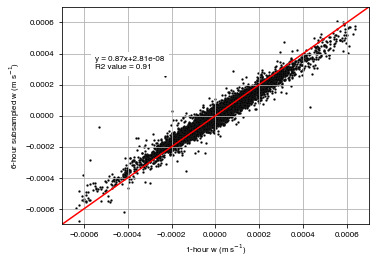

In [10]:
# Compare hourly vs. six-hourly data

# Linear Regression
x, y = ds['W'], ds['W_6']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(r_value**2,slope)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (5.5,4))
ax.scatter(ds['W'],ds['W_6'],5,'k',edgecolors=[0.4, 0.4, 0.4],linewidth=0.1)
ax.plot([-0.001,0.001],[-0.001,0.001],'r-')
ax.set_xlim([-7e-4,7e-4])
ax.set_ylim([-7e-4,7e-4])
ax.set_xlabel('1-hour w (m s$^{-1}$)')
ax.set_ylabel('6-hour subsampled w (m s$^{-1}$)')
ax.grid()
textstr ='y = {slope:.2f}x+{inter:.2e}\nR2 value = {r:.2f}'.format(slope=slope,inter=intercept,r=r_value**2) 
ax.text(-0.00055,0.0003,textstr,fontsize=8,backgroundcolor='white')

# plt.savefig('/Users/kchristensen/Desktop/6hr_subsample.eps', format='eps',dpi=300,bbox_inches='tight')

# Plotting

## Figure 2

/Users/kchristensen/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


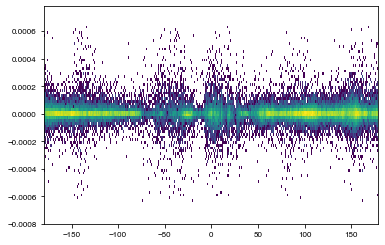

In [11]:
# Initialize the 2D histograms for figure 2
hs1 = plt.hist2d(ds['W'],ds['LAT'],bins=(np.arange(-0.0008,0.0008,0.00002),np.arange(-90,90)),norm=mpl.colors.LogNorm())
newh1 = np.empty(hs1[0].shape)
for ss in range(0,len(hs1[2])-1):
    newh1[:,ss] = (hs1[0][:,ss])/hs1[0][:,ss].sum()
    

hs2 = plt.hist2d(ds['LON'],ds['W'],bins=(np.arange(-180,180),np.arange(-0.0008,0.0008,0.00002)),norm=mpl.colors.LogNorm())
newh2 = np.empty(hs2[0].shape)
for ss in range(0,len(hs2[1])-1):
    newh2[ss,:] = (hs2[0][ss,:])/hs2[0][ss,:].sum()

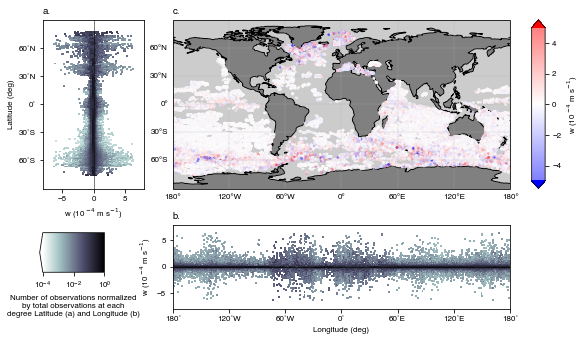

In [12]:
# Figure 2
# Create scattere map along with heat maps of data density compared with lat and lon
cmap2 = plt.get_cmap('bone_r')
fig = plt.figure(figsize=(9,5.5))

ax3 = plt.subplot(1,1,1,projection=crs.PlateCarree())

ax3.coastlines()
ax3.add_feature(cfeature.LAND,color=[0.5,0.5,0.5])
ax3.add_feature(cfeature.OCEAN,color=[0.8,0.8,0.8])
cmap = plt.get_cmap('bwr')

sct = ax3.scatter(ds['LON'],ds['LAT'],s=3,c=ds['W']/(10**-4),transform=crs.PlateCarree(),
                  cmap=cmap,vmin=-5,vmax=5,alpha=0.5)

gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.25)
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False


divider = make_axes_locatable(ax3)
ax_cb = divider.new_horizontal(size="4%", pad=0.3, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cbar = plt.colorbar(sct, cax=ax_cb,extend='both')
cbar.set_label('w (10 $^{-4}$ m s$^{-1}$)')
ax3.set_title('c.',loc='left',fontweight='bold')


ax1 = divider.new_horizontal(size="30%", pad=0.4, axes_class=plt.Axes,sharey=ax3,pack_start=True)
fig.add_axes(ax1)

ax1.plot([0, 0],[-90,90],'k',lw=0.5)
pc1=ax1.pcolor(hs1[1],hs1[2],newh1.transpose(),norm=mpl.colors.LogNorm(vmin=1e-4,vmax=1),cmap=cmap2)

ax1.set_ylabel('Latitude (deg)')
ax1.set_xlabel('w (10 $^{-4}$ m s$^{-1}$)')
ax1.set_yticks([-60,-30,0,30,60])
ax1.set_yticklabels(['60˚S','30˚S','0˚','30˚N','60˚N'])

ax1.set_xlim(-0.0008,0.0008)
ax1.set_ylim(-90,90)
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))

ax1.set_title('a.',loc='left',fontweight='bold')
t = ax1.xaxis.get_offset_text().set_visible(False)

ax2 = divider.new_vertical(size="50%", pad=0.5, axes_class=plt.Axes,sharex=ax3,pack_start=True)
fig.add_axes(ax2)

ax2.plot([-180, 180],[0,0],'k',lw=0.5)
pc2 = ax2.pcolor(hs2[1],hs2[2],newh2.transpose(),norm=mpl.colors.LogNorm(vmin=1e-4,vmax=1),cmap=cmap2,shading='flat')

ax2.set_xlabel('Longitude (deg)')
ax2.set_ylabel('w (10 $^{-4}$ m s$^{-1}$)')
ax2.set_xticks([-180,-120,-60,0,60,120,180])
ax2.set_xticklabels(['180˚','120˚W','60˚W','0˚','60˚E','120˚E','180˚'])
ax2.set_ylim(-0.0008,0.0008)
ax2.set_xlim(-180,180)
plt.ticklabel_format( axis='y',style='sci', scilimits=(-4,4))

ax2.set_title('b.',loc='left',fontweight='bold')
t = ax2.yaxis.get_offset_text().set_visible(False)

cbar_ax = fig.add_axes([0.12, 0.23, 0.1, 0.1])
cb= fig.colorbar(pc2,cax=cbar_ax,orientation="horizontal",extend='min')
cb.set_label('Number of observations normalized\nby total observations at each\ndegree Latitude (a) and Longitude (b)')

# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure2.eps', format='eps',dpi=600,bbox_inches='tight')


## Figure 3

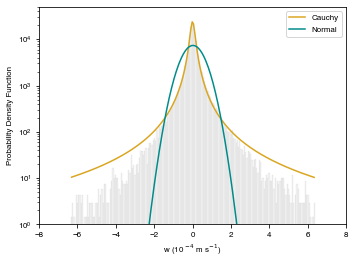

In [13]:
# Figure 3
# Create a histogram for all vertical velocity estimates

fig =  plt.subplots(nrows=1,ncols=1,figsize=(5.5,4))
ylim_vals = 8e-4
bin_num = 200

fff = Fitter(ds['W'],distributions=['cauchy','norm'],bins=bin_num)
fff.fit()
fff.summary(Nbest=6, lw=1.5, plot=True, method='sumsquare_error', clf=True)

ax1 = plt.gca()
ax1.set_xlabel('w (10 $^{-4}$ m s$^{-1}$)')
ax1.set_ylabel('Probability Density Function')
ax1.set_xlim([-ylim_vals, ylim_vals])
ax1.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))

for index in range(bin_num):
    ax1.get_children()[index].set_edgecolor('darkgrey')
    ax1.get_children()[index].set_facecolor([0.95,0.95,0.95])
    ax1.get_children()[index].set_linewidth(0.1)
    
cline = ax1.get_children()[-12]
cline.set(color='darkcyan')
cline = ax1.get_children()[-13]
cline.set(color='goldenrod')

leg = ax1.get_children()[-2]
leg.get_texts()[0].set_text('Cauchy')
leg.legendHandles[0].set_color('goldenrod')
leg.get_texts()[1].set_text('Normal')
leg.legendHandles[1].set_color('darkcyan')


ax1.grid(linewidth=0)
ax1.set_yscale('log')
ax1.set_ylim([1,50000])
t = ax1.xaxis.get_offset_text().set_visible(False)

# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure3.eps', format='eps',dpi=600,bbox_inches='tight')

## Figure 4

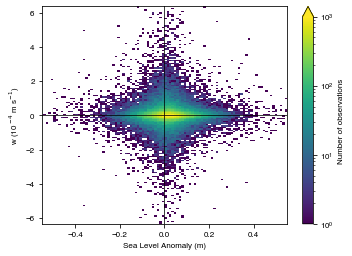

In [14]:
# Figure 4
# Create a 2D histogram for SLA and w
fig = plt.figure(figsize=(5.5,4))

dsla = ds.dropna(dim='INDEX')

plt.hist2d(dsla['SLA'],dsla['W'],bins=150,norm=mpl.colors.LogNorm(vmin=1,vmax=1000))
plt.plot([0,0],[-0.8,0.8], 'k',lw=0.75)
plt.plot([-0.8,1],[0,0], 'k',lw=0.75)
c = plt.colorbar(ax=plt.gca(),extend='max')
plt.xlim([-0.55,0.55])
plt.xlabel('Sea Level Anomaly (m)')
plt.ylabel('w (10 $^{-4}$ m s$^{-1}$)')
c.set_label('Number of observations')

plt.ticklabel_format( axis='y',style='sci', scilimits=(-4,4))
t = plt.gca().yaxis.get_offset_text().set_visible(False)

# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure4.eps', format='eps',dpi=300,bbox_inches='tight')


## Figure 5

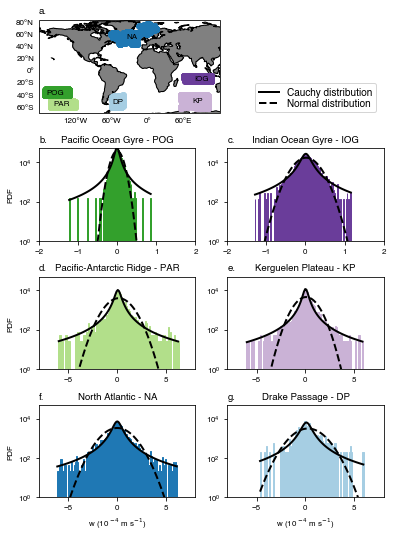

In [15]:
# Figure 5
# Maps and histograms for special areas

# Creating custom color palette
cmdict =  plt.cm.Paired(range(0,12))

r = []
g = []
b = []

for indie in range(0,12):
    if indie <4:
        r += [cmdict[indie][0]]
        g += [cmdict[indie][1]]
        b += [cmdict[indie][2]]
    elif indie > 7:
        r += [cmdict[indie][0]]
        g += [cmdict[indie][1]]
        b += [cmdict[indie][2]]

fig =  plt.figure(figsize=(5.5,7.5))
xlim_vals_neg = -8e-4
xlim_vals_pos = 8e-4
bin_num=100
ylim_vals = 50000

# Indian Ocean Gyre
ax1 = fig.add_subplot(4,2,4)
indoc_f = Fitter(indoc_err['W'],distributions=['cauchy','norm'],bins=bin_num)
indoc_f.fit()
indoc_hist = indoc_f.hist()
indoc_f.plot_pdf()
set_lines_right(ax=plt.gca())
plt.gca().set_title('Indian Ocean Gyre - IOG')
ax1.set_title('c.',loc='left',fontweight='bold')
ax1.set_xlim([xlim_vals_neg/4, xlim_vals_pos/4])
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
ax1.get_legend().remove()
plt.grid(visible='False')
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax1.grid(False)
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[5],g[5],b[5]])
    
# Kerguelen Plateau    
ax2 = fig.add_subplot(4,2,6)
kergl_f = Fitter(kergl_err['W'],distributions=['cauchy','norm'],bins=bin_num)
kergl_f.fit()
kergl_f.hist()
kergl_f.plot_pdf()
# plt.xlabel('Vertical Velocity (m/s)')
# plt.ylabel('PDF')
set_lines_right(ax=plt.gca())
plt.gca().set_title('Kerguelen Plateau - KP')
ax2.set_title('e.',loc='left',fontweight='bold')
ax2.set_xlim([xlim_vals_neg, xlim_vals_pos])
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax2.get_legend().remove()
ax2.grid(False)
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[4],g[4],b[4]])

# Pacific Ocean Gyre
ax3 = fig.add_subplot(4,2,3)
pacoc_f = Fitter(pacoc_err['W'],distributions=['cauchy','norm'],bins=bin_num)
pacoc_f.fit()
pacoc_f.hist()
pacoc_f.plot_pdf()
set_lines_right(ax=plt.gca())
plt.gca().set_title('Pacific Ocean Gyre - POG')
ax3.set_title('b.',loc='left',fontweight='bold')
ax3.set_xlim([xlim_vals_neg/4, xlim_vals_pos/4])
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax3.get_legend().remove()
ax3.grid(False)
plt.ylabel('PDF')
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[3],g[3],b[3]])
    
#Pacific Antarctic Ridge 
ax4 = fig.add_subplot(4,2,5)
parcr_f = Fitter(parcr_err['W'],distributions=['cauchy','norm'],bins=bin_num)
parcr_f.fit()
parcr_f.hist()
parcr_f.plot_pdf()
set_lines_right(plt.gca())
plt.gca().set_title('Pacific-Antarctic Ridge - PAR')
ax4.set_title('d.',loc='left',fontweight='bold')
ax4.set_xlim([xlim_vals_neg, xlim_vals_pos])
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
plt.ylabel('PDF')
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax4.get_legend().remove()
ax4.grid(False)
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[2],g[2],b[2]])

# Map
axm = fig.add_subplot(4,1,1,projection=crs.PlateCarree(central_longitude=0))
axm.coastlines()
axm.add_feature(cfeature.LAND,color=[0.5,0.5,0.5])
axm.scatter(drake['LON'],drake['LAT'],c=[r[0],g[0],b[0]],transform=crs.PlateCarree())
axm.scatter(kergl['LON'],kergl['LAT'],c=[r[4],g[4],b[4]],transform=crs.PlateCarree())
axm.scatter(parcr['LON'],parcr['LAT'],c=[r[2],g[2],b[2]],transform=crs.PlateCarree())
axm.scatter(indoc['LON'],indoc['LAT'],c=[r[5],g[5],b[5]],transform=crs.PlateCarree())
axm.scatter(pacoc['LON'],pacoc['LAT'],c=[r[3],g[3],b[3]],transform=crs.PlateCarree())
axm.scatter(natlt['LON'],natlt['LAT'],c=[r[1],g[1],b[1]],transform=crs.PlateCarree())
axm.text(drake['LON'].mean(),drake['LAT'].mean(),'DP',transform=crs.PlateCarree(),ha='center',va='center')
axm.text(kergl['LON'].mean(),kergl['LAT'].mean(),'KP',transform=crs.PlateCarree(),ha='center',va='center')
axm.text(parcr['LON'].mean(),parcr['LAT'].mean(),'PAR',transform=crs.PlateCarree(),ha='center',va='center')
axm.text(indoc['LON'].mean(),indoc['LAT'].mean(),'IOG',transform=crs.PlateCarree(),ha='center',va='center')
axm.text(pacoc['LON'].mean(),pacoc['LAT'].mean(),'POG',transform=crs.PlateCarree(),ha='center',va='center')
axm.text(natlt['LON'].mean()-8,natlt['LAT'].mean()-5,'NA',transform=crs.PlateCarree(),ha='center',va='center')
axm.set_title('a.',loc='left',fontweight='bold')
axm.set_anchor('W')
gl = axm.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0)
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
 
# North Atlantic
ax5 = fig.add_subplot(4,2,7)
natlt_f = Fitter(natlt_err['W'],distributions=['cauchy','norm'],bins=bin_num)
natlt_f.fit()
natlt_f.hist()
natlt_f.plot_pdf()
set_lines_right(ax=plt.gca())
plt.gca().set_title('North Atlantic - NA')
ax5.set_title('f.',loc='left',fontweight='bold')
plt.ylabel('PDF')
plt.xlabel('w (10 $^{-4}$ m s$^{-1}$)')
ax5.set_xlim([xlim_vals_neg, xlim_vals_pos])
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax5.get_legend().remove()
ax5.grid(False)
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[1],g[1],b[1]])

# Drake Passage
ax6 = fig.add_subplot(4,2,8)
drake_f = Fitter(drake_err['W'],distributions=['cauchy','norm'],bins=bin_num)
drake_f.fit()
drake_f.hist()
drake_f.plot_pdf()
plt.xlabel('w (10 $^{-4}$ m s$^{-1}$)')
set_lines_right(ax=plt.gca())
plt.gca().set_title('Drake Passage - DP')
ax6.set_title('g.',loc='left',fontweight='bold')
ax6.set_xlim([xlim_vals_neg, xlim_vals_pos])
ax6.get_legend().remove()
plt.gca().set_yscale('log')
plt.gca().set_ylim([1,ylim_vals])
plt.ticklabel_format( axis='x',style='sci', scilimits=(-4,4))
ax6.grid(False)
t = plt.gca().xaxis.get_offset_text().set_visible(False)
for index in range(bin_num):
    plt.gca().get_children()[index].set_color([r[0],g[0],b[0]])
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels[0:1])]
fig.legend(lines, ['Cauchy distribution','Normal distribution'],loc = 'lower center',bbox_to_anchor=(0.8, 0.78, 0, 0.5), labelspacing=0.1,fontsize=10)


fig.tight_layout()
# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure5.eps', format='eps',dpi=600,bbox_inches='tight')

## Figure 6

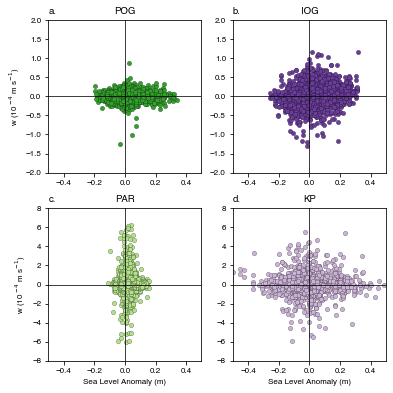

In [16]:
# Figure 6
# Scatter plots of SLA and w for special areas

fig,ax = plt.subplots(nrows=2,ncols=2, figsize=(5.5,5.5))
ylim_vals = 8e-4
xlim_vals = 0.5

# Indian Ocean Gyre
indoc_hist = ax[0][1].scatter(indoc['SLA'],indoc['W'],20,color=[r[5],g[5],b[5]],edgecolors='k',linewidths=0.2)
ax[0][1].set_title('b.',loc='left',fontweight='bold')
ax[0][1].plot([0,0],[-0.8,0.8], 'k',lw=0.75)
ax[0][1].plot([-0.8,1],[0,0], 'k',lw=0.75)
ax[0][1].set_title('IOG')
ax[0][1].set_ylim([-ylim_vals/4, ylim_vals/4])
ax[0][1].set_xlim([-xlim_vals, xlim_vals])
ax[0][1].ticklabel_format(axis='y',style='sci', scilimits=(-4,4))
t = ax[0][1].yaxis.get_offset_text().set_visible(False)

# Kerguelen Plateau
kergl_hist = ax[1][1].scatter(kergl['SLA'],kergl['W'],20,color=[r[4],g[4],b[4]],edgecolors='k',linewidths=0.2)
ax[1][1].set_title('d.',loc='left',fontweight='bold')
ax[1][1].plot([0,0],[-0.8,0.8], 'k',lw=0.75)
ax[1][1].plot([-0.8,1],[0,0], 'k',lw=0.75)
ax[1][1].set_title('KP')
ax[1][1].set_xlabel('Sea Level Anomaly (m)')
ax[1][1].set_ylim([-ylim_vals, ylim_vals])
ax[1][1].set_xlim([-xlim_vals, xlim_vals])
ax[1][1].ticklabel_format(axis='y',style='sci', scilimits=(-4,4))
t = ax[1][1].yaxis.get_offset_text().set_visible(False)

# Pacific Ocean Gyre
pacoc_hist = ax[0][0].scatter(pacoc['SLA'],pacoc['W'],20,color=[r[3],g[3],b[3]],edgecolors='k',linewidths=0.2)
ax[0][0].set_title('a.',loc='left',fontweight='bold')
ax[0][0].plot([0,0],[-0.8,0.8], 'k',lw=0.75)
ax[0][0].plot([-0.8,1],[0,0], 'k',lw=0.75)
ax[0][0].set_title('POG')
ax[0][0].set_ylabel('w (10 $^{-4}$ m s$^{-1}$)')
ax[0][0].set_ylim([-ylim_vals/4, ylim_vals/4])
ax[0][0].set_xlim([-xlim_vals, xlim_vals])
ax[0][0].ticklabel_format(axis='y',style='sci', scilimits=(-4,4))
t = ax[0][0].yaxis.get_offset_text().set_visible(False)

# Pacific Antarctic Ridge
parcr_hist = ax[1][0].scatter(parcr['SLA'],parcr['W'],20,color=[r[2],g[2],b[2]],edgecolors='k',linewidths=0.2)
ax[1][0].set_title('c.',loc='left',fontweight='bold')
ax[1][0].plot([0,0],[-0.8,0.8], 'k',lw=0.75)
ax[1][0].plot([-0.8,1],[0,0], 'k',lw=0.75)
ax[1][0].set_title('PAR')
ax[1][0].set_ylabel('w (10 $^{-4}$ m s$^{-1}$)')
ax[1][0].set_xlabel('Sea Level Anomaly (m)')
ax[1][0].set_ylim([-ylim_vals, ylim_vals])
ax[1][0].set_xlim([-xlim_vals, xlim_vals])
ax[1][0].ticklabel_format(axis='y',style='sci', scilimits=(-4,4))
t = ax[1][0].yaxis.get_offset_text().set_visible(False)


fig.tight_layout()
# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure6.eps', format='eps',dpi=600,bbox_inches='tight')

## Figure 7

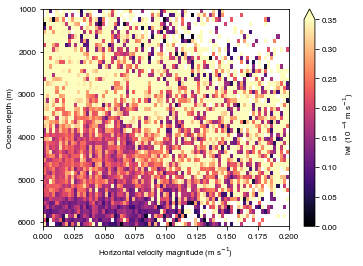

In [17]:
# Figure 7
# Plot the 3D histogram for depth and velocity (horizontal and vertical)

# Averaging the data in bins and removing nans
vels_ds = ssat_data[['ugos','vgos']].sel(longitude=ds['LON'],latitude=ds['LAT'],method='nearest')
vel = vels_ds.mean(dim='time').load()
slopes = root.sel(x=ds['LON'],y=ds['LAT'],method='nearest')

X = np.hypot(vel['ugos'],vel['ugos'])
Y = slopes['z']

Z = abs(ds['W'])
Zerr = abs(werr)

A = np.isnan(X)
X = np.delete(X, A)
Y = np.delete(Y,A)
Z = np.delete(Z,A)
Zerr = np.delete(Zerr,A,axis=1)

B = np.isnan(Y)
X = np.delete(X, B)
Y = np.delete(Y, B)
Z = np.delete(Z, B)
Zerr = np.delete(Zerr,B,axis=1)

X_std = np.std(X)
Y_std = np.std(Y)

xi1 = np.arange(X.min(),X.max(), 0.0025)
yi1 = np.arange(Y.min(),Y.max(), 100)

ddd_pd = pd.DataFrame({
    'U': X.values,
    'Z': Y.values,
    'W': Z.values,})

ddd_pd_werr = pd.DataFrame(Zerr.transpose())
ddd_combo = ddd_pd.join(ddd_pd_werr)

groups = ddd_combo.groupby([pd.cut(ddd_pd.U, xi1),pd.cut(ddd_pd.Z,yi1)])

avs_pd = groups.mean()
num_pd = groups.count()

avg_pd = avs_pd[range(0,100)].mean(axis=1).unstack()
nus_pd = num_pd[range(0,100)].sum(axis=1).unstack()

avgs_pd = avg_pd.where(nus_pd>5)

# Creating the plot
fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (5.5,4))
cntr1 = ax.pcolormesh(xi1,-yi1,avgs_pd.transpose()/1e-4,shading='flat',edgecolors='none',vmin = 0, vmax = 0.35,cmap=cm.magma)

ax.set_xlabel('Horizontal velocity magnitude (m s$^{-1}$)')
ax.set_ylabel('Ocean depth (m)')

ax.set_xlim(0,0.2)
ax.set_ylim(1000,6100)
ax.invert_yaxis()

cc = fig.colorbar(cntr1, ax=ax, extend = 'max')
cc.set_label('|w| (10 $^{-4}$ m s$^{-1}$)') 

# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure8.eps', format='eps',dpi=600,bbox_inches='tight')

## Figure 8

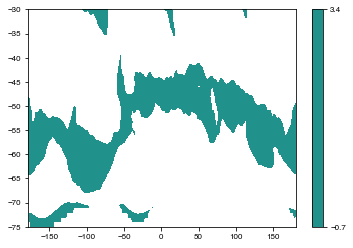

In [18]:
# Pull out just the contours shapes for the SO streamfunction
cs = plt.contourf(sfunc_s['longrid'],sfunc_s['latgrid'],
             sfunc_s['psi'],[-0.7,3.4])
plt.colorbar()
lvl_lookup = dict(zip(cs.collections, cs.levels))

# loop over collections (and polygons in each collection), store in list
PolyList=[]
for col in cs.collections:
    z=lvl_lookup[col] # the value of this level
    for contour_path in col.get_paths():
        # create the polygon for this level
        for ncp,cp in enumerate(contour_path.to_polygons()):
            lons = cp[:,0]
            lats = cp[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])
            if ncp == 0:                
                poly = new_shape # first shape
            else:
                poly = poly.difference(new_shape) # Remove the holes
            
            PolyList.append({'poly':poly,'props':{'z': z}})

In [19]:
# Find all of the estimates inside of the ACC polygon (#5)
inpoly = []
for indie in range(0,len(ds['LAT'])):
    p1 = Point(ds['LON'].isel(INDEX=indie), ds['LAT'].isel(INDEX=indie))
    if p1.within(PolyList[5]['poly']):
        inpoly+=[indie]
        
polyds = ds.isel(INDEX=inpoly)

In [20]:
# Get the depth data within the polygon
pbounds = PolyList[5]['poly'].bounds
garroot = root['z'].sel(y=slice(pbounds[1],pbounds[3]))

inpoly_z = np.zeros(garroot.shape)
for indie_y in range(0,len(garroot['y'])):
    for indie_x in range(0,len(garroot['x'])):
        p1 = Point(float(garroot['x'].isel(x=indie_x).values),float(garroot['y'].isel(y=indie_y).values))
        if p1.within(PolyList[5]['poly']):
            inpoly_z[indie_y,indie_x] = 1
            

In [21]:
# # Plot only the points inside of the polygon
# cmap2 = plt.get_cmap('bwr')
# f = plt.figure(figsize=(14,14))
# ax = plt.axes(projection=crs.PlateCarree())
# ax.set_extent([-179, 179, -90, 0])
# ax.coastlines()
# ax.add_feature(cfeature.LAND,color=[0.3,0.3,0.3])
# ax.add_feature(cfeature.OCEAN,color=[0.8,0.8,0.8])

# sct = plt.scatter(polyds['LON'],polyds['LAT'],5,polyds['W'],transform=crs.PlateCarree(),cmap=cmap2)

# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# gl.xlabel_style = {'size': 20, 'color': 'k'}
# gl.ylabel_style = {'size': 20, 'color': 'k'}

# sct.set_clim(-0.0005, 0.0005)
# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)


In [22]:
# Create a running mean for w and z in the ACC polygon
spacing = 2
window = 2
lonlist = np.arange(-180, 180+spacing, spacing)

sarroot = -garroot.where(garroot<0).where(inpoly_z).mean(dim='y').groupby_bins('x',lonlist).mean()

avgvals = np.empty((len(lonlist)-1))
avgvals[:] = np.nan
stdvals = np.empty((len(lonlist)-1))
stdvals[:] = np.nan
avgvals_2 = np.empty((len(lonlist)-1))
avgvals_2[:] = np.nan
stdvals_2 = np.empty((len(lonlist)-1))
stdvals_2[:] = np.nan

testavbath = []
for indie in range(0,len(sarroot)):
    if indie < window:
        hh = sarroot.roll(x_bins=window-indie).isel(x_bins=slice(0,window*2)).mean()
    elif indie > len(sarroot)-window:  
        hh = sarroot.roll(x_bins=indie-(len(sarroot)-1)-window).isel(x_bins=slice(len(sarroot)-window*2,len(sarroot))).mean()
    else:
        hh =  sarroot.isel(x_bins=slice(indie-window,indie+window)).mean()
    testavbath += [hh.values]  

for index_lon in range(0,len(lonlist)-1):
    botlon = lonlist[index_lon] - window
    toplon = lonlist[index_lon] + window
    
    if botlon<-180:
        vels =  polyds['W'].where(((polyds['LON']>-180) & (polyds['LON']<=toplon)) |
                                  ((polyds['LON']>179) & (polyds['LON']<=180)),drop=True)
    elif toplon>180:
        vels = polyds['W'].where(((polyds['LON']>-180) & (polyds['LON']<=-179)) | 
                                 ((polyds['LON']>botlon) & (polyds['LON']<=180)),drop=True)
    else:
        vels = polyds['W'].where((polyds['LON']>botlon) & (polyds['LON']<=toplon),drop=True)
                            
    if len(vels) > 15:
        avgvals[index_lon] = abs(vels).mean()
        stdvals[index_lon] = vels.std()
        avgvals_2[index_lon] = abs(vels).mean()
        stdvals_2[index_lon] = vels.std()
    elif (len(vels) < 15) & (len(vels) > 0):
        avgvals_2[index_lon] = abs(vels).mean()
        stdvals_2[index_lon] = vels.std()


/Users/kchristensen/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


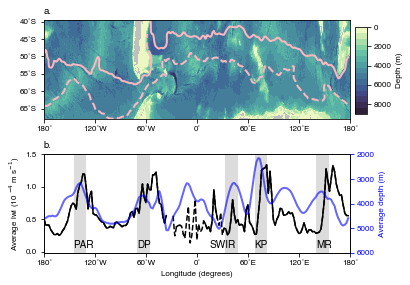

In [23]:
# Figure 8
# Plot the bathymetry and vertical velocity running means with the bathymetry map
f =  plt.figure(figsize=(5.5,4))

ax = f.add_subplot(2,1,1)
ax.set_ylim(pbounds[1],pbounds[3])
ax.set_xlim(-180,180)
levels=np.linspace(0,9000,16)
avgarroot = garroot.groupby_bins('x',np.arange(-180,180,0.05)).mean().groupby_bins('y',np.arange(-70,-35,0.05)).mean()
avgarroot = avgarroot.where(avgarroot<0)
ctfgar = ax.contourf(np.arange(-180,180,0.05)[:-1],np.arange(-70,-35,0.05)[:-1],-avgarroot,
                     levels=levels,cmap=cmocean.cm.deep)

ax.patch.set_color('.75')
ax.contour(sfunc_s['longrid'],sfunc_s['latgrid'],
             sfunc_s['psi'],[-0.7,3.4],colors='lightpink',linewidths=2)

ax.set_xticks([-180,-120,-60,0,60,120,180])
ax.set_xticklabels(['180˚','120˚W','60˚W','0˚','60˚E','120˚E','180˚'])
ax.set_yticks([-65,-60,-55,-50,-45,-40])
ax.set_yticklabels(['65˚S','60˚S','55˚S','50˚S','45˚S','40˚S'])

cb_ax = f.add_axes([.9,0.6,.03,.3])
cbar = f.colorbar(ctfgar,orientation='vertical',cax=cb_ax,extend='both',ticks=np.arange(0,9000,2000))
divider = make_axes_locatable(ax)
cbar.set_label('Depth (m)')
cbar.ax.invert_yaxis()
ax.set_title('a.',loc='left',fontweight='bold')

ax1 = f.add_subplot(2,1,2,sharex = ax)

left, bottom, width, height = (-70, -0.1, 15, 2)
ax1.text(left,0.05,'DP',fontsize=10)
rect_drake = plt.Rectangle((left, bottom), width, height,
                     facecolor="gainsboro")

left, bottom, width, height = (33, -0.1, 15, 2)
ax1.text(left-3,0.05,'SWIR',fontsize=10,ha='center')
rect_swir = plt.Rectangle((left, bottom), width, height,
                     facecolor="gainsboro")

left, bottom, width, height = (68, -0.1, 15, 2)
ax1.text(left,0.05,'KP',fontsize=10)
rect_kergl = plt.Rectangle((left, bottom), width, height,
                     facecolor="gainsboro")

left, bottom, width, height = (-145, -0.1, 15, 2)
ax1.text(left,0.05,'PAR',fontsize=10)
rect_pacrc = plt.Rectangle((left, bottom), width, height,
                     facecolor="gainsboro")

left, bottom, width, height = (140, -0.1, 15, 2)
ax1.text(left,0.05,'MR',fontsize=10)
rect_macqr = plt.Rectangle((left, bottom), width, height,
                     facecolor="gainsboro")

ax1.add_patch(rect_drake)
ax1.add_patch(rect_swir)
ax1.add_patch(rect_pacrc)
ax1.add_patch(rect_macqr)
ax1.add_patch(rect_kergl)


ax1.plot(lonlist[:-1], avgvals/1e-4,'k')
ax1.plot(lonlist[:-1],avgvals_2/1e-4,'k--')

ax1.set_xlabel('Longitude (degrees)')
ax1.set_ylabel('Average |w| (10 $^{-4}$ m s$^{-1}$)', color='k')
ax1.set_xlim(-180,180)
ax1.set_xticks([-180,-120,-60,0,60,120,180])
ax1.set_xticklabels(['180˚','120˚W','60˚W','0˚','60˚E','120˚E','180˚'])
ax1.set_ylim([-0.02,1.5])
t = ax1.yaxis.get_offset_text().set_visible(False)

ax2 = ax1.twinx()
agarroot = testavbath
ax2.plot(lonlist[:-1],agarroot,'b',lw=2,alpha=0.6)

ax2.set_ylabel('Average depth (m)', color='b')
ax2.tick_params(axis='y',  colors='b')
ax2.set_xlim(-180,180)
ax2.set_ylim([2000,6000])
ax2.invert_yaxis()
ax2.set_title('b.',loc='left',fontweight='bold')
f.tight_layout()

# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure8.eps', format='eps',dpi=600,bbox_inches='tight')


## Figure 9

In [29]:
# Select the necessary level (nearest 1000dbar) and get the 2D coordinates
wsel = wdata.sel(k_l = 29)
W_array = wsel['WVELMASS'].values.ravel()

# Create a mask for grid cells with floats within 100km
full_mask = np.zeros(wsel['WVELMASS'].mean(dim='time').shape)
for index in range(0,13):
    spi = 100000
    tile = wsel.isel(tile=index)
    tile = tile.where((tile['YC']>np.min(ds['LAT'])) & (tile['YC']<np.max(ds['LAT'])))
    tmin_lat = tile['YC'].min()
    tmax_lat = tile['YC'].max()
    tmin_lon = tile['XC'].min()
    tmax_lon = tile['XC'].max()

    if tmin_lon <-170:
        tile1 = tile.copy()
        tile1['XC'] = tile['XC'].where(tile['XC']<0)
        tmin_lon1 = tile1['XC'].min()
        tmax_lon1 = tile1['XC'].max()
        flt_t1 = ds.where((ds['LON']<tmax_lon1) & (ds['LON']>=tmin_lon1) &
                          (ds['LAT']<tmax_lat) & (ds['LAT']>tmin_lat), drop=True)
        lons_1d_1 = flt_t1['LON']
        lats_1d_1 = flt_t1['LAT']
        tile2 = tile.copy()
        tile2['XC'] = tile['XC'].where(tile['XC']>0)
        tmin_lon2 = tile2['XC'].min()
        tmax_lon2 = tile2['XC'].max()
        flt_t2 = ds.where((ds['LON']<=tmax_lon2) & (ds['LON']>tmin_lon2) &
                          (ds['LAT']<tmax_lat) & (ds['LAT']>tmin_lat), drop=True)
        lons_1d_2 = flt_t2['LON']
        lats_1d_2 = flt_t2['LAT']
        lons_1d = np.concatenate([lons_1d_1.values, lons_1d_2.values])
        lats_1d = np.concatenate([lats_1d_1.values, lats_1d_2.values])
        W_1d = np.concatenate([flt_t1['W'].values, flt_t2['W'].values])    

    else:
        flt_t = ds.where((ds['LON']<tmax_lon) & (ds['LON']>tmin_lon) & 
                         (ds['LAT']<tmax_lat) & (ds['LAT']>tmin_lat),drop=True)
        lons_1d = flt_t['LON']
        lats_1d = flt_t['LAT']
        W_1d = flt_t['W'].values

    orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)
    new_grid  = pyresample.geometry.SwathDefinition(lons=tile['XC'],lats=tile['YC'])

    field = pyresample.kd_tree.resample_nearest(orig_grid, W_1d,
                                                new_grid,
                                                radius_of_influence=spi,
                                                fill_value=None)

    full_mask[index,:,:] = field.mask

X = np.tile(full_mask, (len(wsel.time),1,1,1))
w_masked = wsel.where(~X.astype(bool))

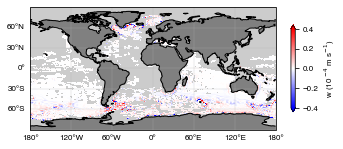

In [30]:
# Create the figure
mapper = LLCMapper(w_masked)
ax,cb = mapper((w_masked['WVELMASS']/1e-4).mean(dim='time'),vmin=-0.4,vmax=0.4,cmap=plt.get_cmap('bwr'))
cb.set_label('w (10 $^{-4}$ m s$^{-1}$)') 
# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure9.jpg', format='jpg',dpi=600, bbox_inches='tight')

## Figure 10

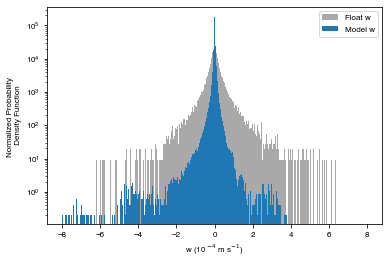

In [31]:
plt.hist(ds['W'],color='darkgrey',bins=np.arange(-0.0008,0.0008,0.000001),density=True)
plt.hist(w_masked['WVELMASS'].values.ravel(),bins=np.arange(-0.0008,0.0008,0.000001),density=True)
plt.gca().set_yscale('log')
plt.xlabel('w (10 $^{-4}$ m s$^{-1}$)')
plt.ylabel('Normalized Probability \n Density Function')
plt.legend(['Float w','Model w'])

plt.ticklabel_format(axis='x',style='sci', scilimits=(-4,4))
t = plt.gca().xaxis.get_offset_text().set_visible(False)
# plt.savefig('/Users/kchristensen/Desktop/wpaperfigs/Figure10.pdf', format='pdf',dpi=600,bbox_inches='tight')